In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
###Downloading hand gesture dataset
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Download the dataset to local google drive.
id = "1cjMvG8dyEzTtDkWd9fHDSjvZ5NZCLFMs"
downloaded = drive.CreateFile({"id":id})
downloaded.GetContentFile("DataSet.zip")
!unzip "/content/DataSet.zip" -d "/content/"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data/550.jpg   
  inflating: /content/data/5500.jpg  
  inflating: /content/data/5501.jpg  
  inflating: /content/data/5502.jpg  
  inflating: /content/data/5503.jpg  
  inflating: /content/data/5504.jpg  
  inflating: /content/data/5505.jpg  
  inflating: /content/data/5506.jpg  
  inflating: /content/data/5507.jpg  
  inflating: /content/data/5508.jpg  
  inflating: /content/data/5509.jpg  
  inflating: /content/data/551.jpg   
  inflating: /content/data/5510.jpg  
  inflating: /content/data/5511.jpg  
  inflating: /content/data/5512.jpg  
  inflating: /content/data/5513.jpg  
  inflating: /content/data/5514.jpg  
  inflating: /content/data/5515.jpg  
  inflating: /content/data/5516.jpg  
  inflating: /content/data/5517.jpg  
  inflating: /content/data/5518.jpg  
  inflating: /content/data/5519.jpg  
  inflating: /content/data/552.jpg   
  inflating: /content/data/5520.jpg  
  inflating: /content/data/5521.jpg  
  inflating: /content/d

In [25]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
import os 
from torchvision import datasets, transforms, utils
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import re
from io import StringIO
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models as models
from PIL import Image
import matplotlib
from csv import DictReader
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import trange
torch.__version__
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')
torch.set_default_tensor_type(torch.FloatTensor)

We are using GPU.


In [26]:
# preprocess train data
trainingFilePath = "/content/train.csv"
image_id = []
labels = []
with open(trainingFilePath, newline='') as csvfile:
    reader = DictReader(csvfile)
    for row in reader:
      image_id.append(row['ImageID'])
      labels.append(row['Labels'])
image_id = np.array(image_id)
labels = np.array(labels)

In [27]:
# Devide image ids into file_train, file_validation
file = [os.path.join("/content/data",i) for i in image_id]
# print(file)
file_train = file[0:20000]
file_validation = file[20000:]

In [28]:
# Devide lavels into label_train, label_validation
label_npArray = np.zeros(shape=[1,20], dtype=np.float)

for i in labels:
    label_item = np.zeros(shape=[1,20], dtype=np.float)
    for item in i.split(' '):
        label_item[0,int(item)] = 1
    label_npArray = np.vstack((label_npArray,label_item))

label_npArray = label_npArray[1:,:]
label_train = label_npArray[0:20000, :]
label_validation = label_npArray[20000:, :]
print(label_train.shape)

(20000, 20)


In [29]:
# preprocess test data
testFilePath = "/content/test.csv"
image_test_id = []
with open(testFilePath, newline='') as csvfile:
    reader = DictReader(csvfile)
    for row in reader:
      image_test_id.append(row['ImageID'])
image_test_id = np.array(image_test_id)

file = [os.path.join("/content/data",i) for i in image_test_id]
file_test = file

In [30]:
# statistics numbers of label
label_dic={}
for l in range(20):
    label_dic[l] = np.sum(label_npArray[:,l])
df = pd.DataFrame(list(label_dic.items()), columns=['label', 'count']).sort_values(by = 'count',axis = 0,ascending = False)
print('Total labels:',len(df))
df.head(20)

Total labels: 20


,label,count
1,1,22797.0
3,3,4365.0
8,8,2210.0
15,15,1934.0
18,18,1525.0
10,10,1471.0
17,17,1430.0
6,6,1395.0
4,4,1272.0
7,7,1221.0


Text(0.5, 0, 'Label')

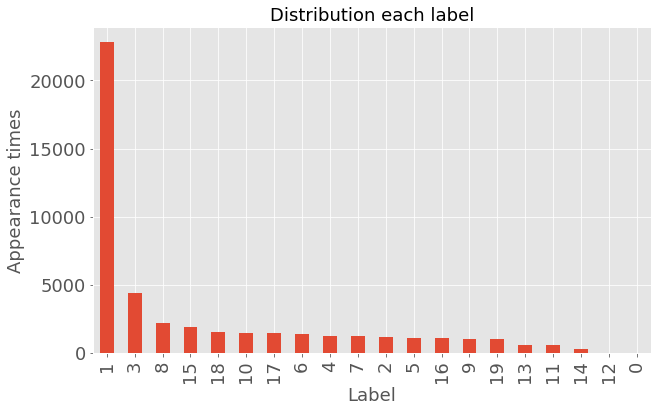

In [31]:
# plot the distribution
df[:20].plot(x='label', y='count', kind='bar', legend=False, grid=True, figsize=(10, 6),fontsize=18)
plt.title("Distribution each label",fontsize=18)
plt.ylabel('Appearance times', fontsize=18)
plt.xlabel('Label', fontsize=18)

{1: 19377, 2: 6651, 3: 2563, 5: 339, 4: 978, 6: 81, 7: 11}


Text(0.5, 0, 'Label number')

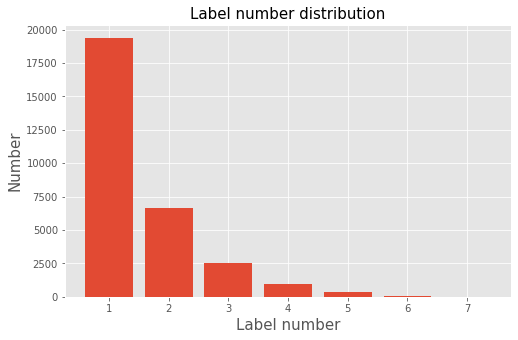

In [32]:
# statistics numbers of multilabel
labelCount={}
for i in range(label_npArray.shape[0]):
    counter = int(np.sum(label_npArray[i,:]))
    labelCount[counter] = labelCount.get(counter,0)+1
print(labelCount)
#plot
plt.figure(figsize=(8,5))
plt.bar(labelCount.keys(), labelCount.values())
plt.title("Label number distribution",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Label number', fontsize=15)

In [33]:
# https://blog.csdn.net/xys430381_1/article/details/85724668 
# Initialize the parameters of transforms.Normalize
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

preprocess = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        normalize
    ]
)

def default_loader(path):
    img = Image.open(path)
    img_tensor = preprocess(img)
    return img_tensor

# Custom trainset class
class trainset(Dataset):
    
    def __init__(self, loader=default_loader):
        # define the paths of images
        self.images = file_train
        self.target = torch.tensor(label_train, dtype=float)
        self.loader = loader
        
    def __getitem__(self, index):
        fn = self.images[index]
        img = self.loader(fn)
        target = self.target[index]
        return img,target
    
    def __len__(self):
        return len(self.images)

# Custom trainset class    
class validationset(Dataset):
    
    def __init__(self, loader=default_loader):
        self.images = file_validation
        self.target = torch.tensor(label_validation, dtype=float)
        self.loader = loader
    
    def __getitem__(self, index):
        fn = self.images[index]
        img = self.loader(fn)
        target = self.target[index]
        return img,target
    
    def __len__(self):
        return len(self.images)

# Custom trainset class   
class testset(Dataset):
    def __init__(self, loader=default_loader):
        self.images = file_test
        self.loader = loader
    
    def __getitem__(self, index):
        fn = self.images[index]
        img = self.loader(fn)
        return img
    
    def __len__(self):
        return len(self.images)

In [35]:
from torchvision import models as models
# model function
def model(pretrained, requires_grad):
    model = models.resnet101(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 20 classes in total
    fc_features = model.fc.in_features
    model.fc = nn.Linear(fc_features, 20)
    
    return model

In [36]:
model = model(pretrained=True, requires_grad=False)

In [37]:
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
# train function
def train(model, dataloader, optimizer, criterion, train_data, device, scaler):
  print('Training')
  model.train().to(device)
  counter = 0
  train_running_loss = 0.0
  for i, (data,target) in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
    counter += 1
    optimizer.zero_grad()
    data, target = data.to(device), target.to(device)
    with autocast():
      outputs = model(data)
      loss = criterion(outputs.float(), target.float())
    train_running_loss += loss.item()
    # backpropagation
    scaler.scale(loss).backward()
    # update optimizer parameters
    scaler.step(optimizer)
    scaler.update()
      
  train_loss = train_running_loss / counter
  return train_loss

In [38]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
  print('Validating')
  model.eval().to(device)
  counter = 0
  val_running_loss = 0.0
  with torch.no_grad():
    for i, (data,target) in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
        counter += 1
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        val_running_loss += loss.item()
      
  val_loss = val_running_loss / counter
  return val_loss

In [39]:
# load data
train_data = trainset()
validation_data = validationset()
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)
testloader = DataLoader(validation_data, batch_size=256)
matplotlib.style.use('ggplot')
# intialize the model
model = model.to(device)
# learning parameters
lr = 0.0002
epochs = 20
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.BCEWithLogitsLoss()

scaler = GradScaler()
# start the training and validation
train_loss = []
valid_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, optimizer, criterion, train_data, device, scaler
    )
    valid_epoch_loss = validate(
        model, testloader, criterion, validation_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}", )
    print(f'Val Loss: {valid_epoch_loss:.4f}')

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1 of 20
Training


79it [01:25,  1.08s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.20s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.2149
Val Loss: 0.1658
Epoch 2 of 20
Training


79it [01:25,  1.08s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:48,  1.20s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1537
Val Loss: 0.1440
Epoch 3 of 20
Training


79it [01:23,  1.06s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.19s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1355
Val Loss: 0.1291
Epoch 4 of 20
Training


79it [01:22,  1.05s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.19s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1224
Val Loss: 0.1190
Epoch 5 of 20
Training


79it [01:21,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1144
Val Loss: 0.1123
Epoch 6 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1091
Val Loss: 0.1074
Epoch 7 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.19s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1042
Val Loss: 0.1046
Epoch 8 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1014
Val Loss: 0.1016
Epoch 9 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0995
Val Loss: 0.1001
Epoch 10 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0968
Val Loss: 0.0982
Epoch 11 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0953
Val Loss: 0.0968
Epoch 12 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0939
Val Loss: 0.0958
Epoch 13 of 20
Training


79it [01:21,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0928
Val Loss: 0.0949
Epoch 14 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0919
Val Loss: 0.0941
Epoch 15 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0917
Val Loss: 0.0937
Epoch 16 of 20
Training


79it [01:21,  1.03s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0907
Val Loss: 0.0928
Epoch 17 of 20
Training


79it [01:21,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.18s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0897
Val Loss: 0.0926
Epoch 18 of 20
Training


79it [01:22,  1.04s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:47,  1.19s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0891
Val Loss: 0.0921
Epoch 19 of 20
Training


79it [01:24,  1.06s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:48,  1.21s/it]                        
  0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0886
Val Loss: 0.0913
Epoch 20 of 20
Training


79it [01:25,  1.08s/it]
  0%|          | 0/39 [00:00<?, ?it/s]

Validating


40it [00:49,  1.23s/it]                        

Train Loss: 0.0879
Val Loss: 0.0915


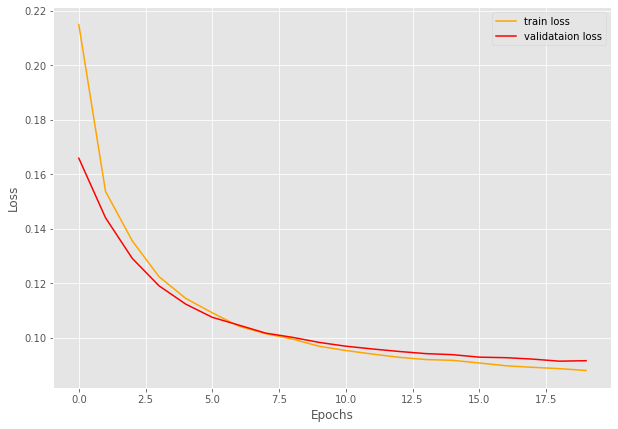

In [40]:
# save the trained model to disk
model.half()
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'model.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [41]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)

In [43]:
model.eval() ## or model.train()
results = []
testloader = DataLoader(validation_data, batch_size=200)
outputs = np.zeros(shape=[1,20], dtype=np.float)
targets = np.zeros(shape=[1,20], dtype=np.float)
# for _, image in enumerate(testLoader):
for _, (image,target) in enumerate(trainloader):
  image = image.to(device).half()
  output = 0
  with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output)
  output = output.cpu().numpy()
  outputs = np.vstack((outputs,output))  
  target = target.cpu().numpy()   
  targets = np.vstack((targets,target)) 
outputs = outputs[1:, :]
targets = targets[1:, :]

resultDict = {}
resultDict_1 = {}
for threshold in np.arange(0.2, 0.8, 0.001):
  _outputs = np.where(outputs>threshold, 1, 0)
  resultDict[threshold] = f1_score(targets, _outputs, average="samples")
res = max(resultDict, key=lambda x: resultDict[x])
print(resultDict)
print(res)

{0.2: 0.8009686840936842, 0.201: 0.8014463283938283, 0.202: 0.8017937887112887, 0.203: 0.8019247086247085, 0.20400000000000001: 0.8022669200244199, 0.20500000000000002: 0.8024062345987346, 0.20600000000000002: 0.8029260289710289, 0.20700000000000002: 0.8030964418914418, 0.20800000000000002: 0.8033051293151293, 0.20900000000000002: 0.8036306757131757, 0.21000000000000002: 0.8036589260739261, 0.21100000000000002: 0.8036952103452102, 0.21200000000000002: 0.8040859002109001, 0.21300000000000002: 0.8043755394605394, 0.21400000000000002: 0.8047822602397602, 0.21500000000000002: 0.8048754204129204, 0.21600000000000003: 0.8049828807303807, 0.21700000000000003: 0.8052704673104673, 0.21800000000000003: 0.8055203482628482, 0.21900000000000003: 0.8057251245976246, 0.22000000000000003: 0.8059241325341325, 0.22100000000000003: 0.8061733785658786, 0.22200000000000003: 0.8064016233766234, 0.22300000000000003: 0.8066373917748917, 0.22400000000000003: 0.8069138455988456, 0.22500000000000003: 0.807004653

In [44]:
print(resultDict[res])

0.8186464088689088


In [45]:
from sklearn.metrics import f1_score
import pandas as pd
# load the model checkpoint
checkpoint = torch.load('model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
scores = []
results = []
for _, (data, target) in enumerate(testloader):
  data, target = data.to(device).half(), target.to(device).half()
  # get the predictions by passing the image through the model
  outputs = model(data)
  outputs = torch.sigmoid(outputs)
  outputs = outputs.detach().cpu().numpy()
  outputs = np.where(outputs>res,1,0)
  target = target.cpu().numpy() 
  score = f1_score(target,outputs, average='samples')
  scores.append(score)
  for i in range(outputs.shape[0]):
      string = ""  
      result = np.argwhere(outputs[i,:] == 1)
      result = result[:,-1]
      for i in result:
          string += str(i)+" " 
      results.append(string.strip())
          
scores = np.array(scores)
print(results)
dataFrame = pd.DataFrame()
dataFrame['ImageID'] = image_id[20000:]
dataFrame['Labels'] = results
dataFrame['Targets'] = labels[20000:]
dataFrame.to_csv('result.csv')
print(np.mean(scores))

    

['1', '1', '1', '', '1 3', '1 3 8', '1 3', '16', '1 2 3', '1', '', '1', '18', '1', '1', '1 3', '1', '1', '3 10', '1', '1', '1', '1 9', '1 3 8 10', '1 10', '1', '1', '1 15', '1', '1', '1', '1 3 4', '1', '1', '1 3', '1 16', '1 2 3 19', '17', '1', '18', '1', '1', '1', '1', '1', '1', '1 18', '17', '1 3 6 8', '1 3', '17', '1', '1', '1 2 4', '1', '1', '16', '1', '1', '1', '1', '17', '17', '1 3', '1', '1', '1 5', '1 19', '3 10', '1', '1', '1', '1', '1', '1', '1', '1', '1', '3', '1', '1 3 4', '1', '1', '5 8', '1', '1', '', '16', '1', '1', '1', '1 5', '1 3 6 8', '1', '1', '3 4', '17', '1', '1 3', '1', '1', '', '1 3 8', '1 15', '3 11', '1', '1 9', '1 19', '1 5', '1', '1', '1', '1', '1', '1 19', '1', '1 15', '1 17', '1 3 6', '1', '1', '1', '1', '1 3', '18 19', '13', '1', '1', '1', '1', '1 5', '18', '1', '1', '1 3 13', '8', '1', '1 17', '5', '1 3 8 18', '1', '1', '1', '1', '1 19', '1 7', '1', '1', '1', '1', '1', '1', '1 5', '1', '1', '1', '1', '1 9', '1', '1 3', '7', '1', '1', '15', '1 3 5 8', '1'

In [46]:
# load the model checkpoint
checkpoint = torch.load('model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = testset()
testloader = DataLoader(test_data, batch_size=256)
results = []
for counter, data in enumerate(testloader):
  data = data.to(device).half()
  # get the predictions by passing the image through the model
  outputs = model(data)
  outputs = torch.sigmoid(outputs)
  outputs = outputs.detach().cpu().numpy()
  outputs = np.where(outputs>res,1,0)
  for i in range(outputs.shape[0]):
      string = ""  
      result = np.argwhere(outputs[i,:] == 1)
      result = result[:,-1]
      for i in result:
          string += str(i)+" " 
      results.append(string.strip())
            
dataFrame = pd.DataFrame()
dataFrame['ImageID'] = image_test_id
dataFrame['Labels'] = results
dataFrame.to_csv('submission.csv', index=None)